# Tutorial for Human Gesture Recognition

In [1]:
import yaml
import torch
import torch.nn as nn
from tqdm import tqdm
import os

## Dataset with M-Gesture: 
Point cloud gesture dataset collected using FMCW mmWave Radar, TI-IWR1443 single-chip 76-GHz to 81-GHz mmWave sensor evaluation module. 2 scenarios are included: 
    short range (i.e. Human-Radar Distance(HRD) < 0.5 m) and long range (i.e. 2m < HRD < 5m); Only long-range gesture recognition 
    is supported as only long-range dataset contain point cloud data.

### Load the data

In [2]:
from dataset.hgr import load_hgr_dataset
# The path contains the radHAR dataset
root =  '/home/junqiao/projects/data/mGesture'
train_dataset, test_dataset = load_hgr_dataset("M-Gesture", root)

using dataset: M-Gesture DATA


Generating 21356 samples...
Generating 4359 samples...


### Visualize the point cloud

(28, 50, 5) <class 'int'>


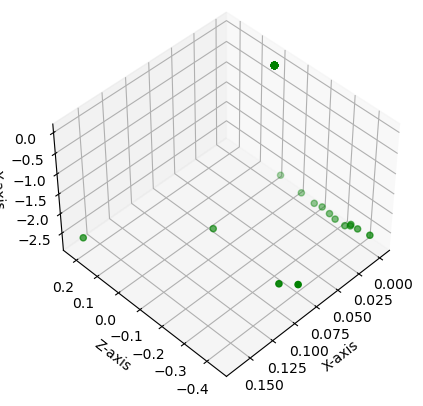

In [3]:
from matplotlib import pyplot as plt
from plot import plot_3d_graph
# Example of the samples in the dataset
index = 9  # Randomly select an index
pc,gesture = train_dataset.__getitem__(index)
print(pc.shape, type(gesture))
plot_3d_graph(None, pc[8])

## Create model 
M-Gesture utilizes CNN-based model, EVL_NN with feature engineering module called RPM as the baseline hgr method. From model.hgr, we can import desired hgr model designed for mmWave PC. The model parameter for EVL_NN reimplemented for M-Gesture is as follows:

In [4]:
from model.hgr import EVL_NN
model = EVL_NN(dataset="M-Gesture", num_classes=4)
print(model)

EVL_NN(
  (C1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  )
  (M): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 1), dilation=1, ceil_mode=False)
  (E1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (E2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (F): Sequential(
    (0): Linear(in_features=1792, out_features=256, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)


## Model Train
pysensing library support quick training of model with the following steps. The training interface incorporates pytorch loss functions, optimizers and dataloaders to facilate training. An example is provided for how to define the aforemetioned terms.

In [5]:
# Create pytorch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16)

# Define pytorch loss function as criterion 
criterion = nn.CrossEntropyLoss()

# Define pytorch optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# GPU acceleration with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A quick training using har_train. The resulted model parameters will be saved into "train_{num_epochs}.pth".

In [6]:
# Pysensing training interface
from inference.hgr import hgr_train
hgr_train(model, train_loader, num_epochs=1, optimizer=optimizer, criterion=criterion, device=device)

Epoch:1, Accuracy:0.5130,Loss:1.203937649
Save model at train_1.pth...


### Model inference

Load the pretrained model, e.g. from train_1.pth, and perform human gesture recognition!

In [7]:
## load pretrained model
ckpt = torch.load('train_1.pth')['model_state_dict']
model.load_state_dict(ckpt)
model.eval()

EVL_NN(
  (C1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  )
  (M): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 1), dilation=1, ceil_mode=False)
  (E1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (E2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (F): Sequential(
    (0): Linear(in_features=1792, out_features=256, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [8]:

idx = 5
pc, label= test_dataset.__getitem__(idx)
print(pc.shape)
predicted_result = model(torch.tensor(pc).unsqueeze(0).float().to(device))
print("The predicted gesture is {}, while the ground truth is {}".format(label,torch.argmax(predicted_result).cpu()))

(28, 50, 5)
The predicted gesture is 1, while the ground truth is 1
